We are going to create a Neural Network to classify images of handwritten digits.
For this we will use PyTorch

In [5]:
# Let's import the libraries
import torch # PyTorch

from torchvision import datasets  # For downloading the dataset
from torchvision.transforms import ToTensor  # For converting data to Tensors
import matplotlib.pyplot as plt  # For plotting images and labels


In [3]:
# Detect GPU
device = (
    "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device}")

Using cpu


We will use the MNIST dataset, which contains a total of 60,000 images, each with a handwritten digit (between 0 and 9). Additionally, each image has its corresponding label (a numerical value between 0 and 9).

In [6]:
# Downloading the dataset and save it in "data" directory:

data_mnist = datasets.MNIST(
    root="data",  # Folder where the dataset will be stored
    train=True,  # True: download 60,000 train images, False: doanload 10,000 test images
    download=True,
    transform=ToTensor()  # Convert images to tensors
)


Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



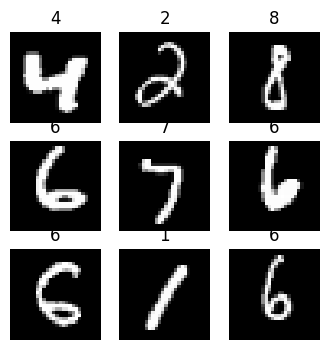

In [9]:
figure = plt.figure(figsize=(4, 4))
rows, cols = 3, 3

for i in range(1, cols * rows + 1):
    # Choose a random image
    sample_idx = torch.randint(len(data_mnist), size=(1,)).item()

    # Extract image and label
    img, label = data_mnist[sample_idx]

    # Plot
    figure.add_subplot(rows, cols, i)
    plt.title(str(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")  
plt.show()


Train, Valid, Test

In [30]:
# The torch.manual_seed() function is used to set the seed for generating random numbers in PyTorch. 
# This ensures that the random numbers generated are reproducible, which is crucial for debugging and ensuring 
# that experiments are consistent.
torch.manual_seed(123)

In [31]:
# split the data_mnist dataset into three separate datasets: training, validation, and test sets. 

total_size = len(data_mnist)  # Typically 60,000 for the MNIST training set
train_size = int(0.8 * total_size)  # 80% of 60,000 -> 48,000
val_size = int(0.1 * total_size)    # 10% of 60,000 -> 6,000
test_size = total_size - train_size - val_size  # Remaining samples -> 6,000

train, val, test = torch.utils.data.random_split(
    data_mnist, [train_size, val_size, test_size]
)


# Deep Learning Model

Input Layer: 784 elements (since the MNIST images are 28x28 pixels, flattened into a 784-element vector). 

Hidden Layer: 15 neurons with ReLU activation.

Output Layer: 10 neurons with softmax activation (one for each digit class 0-9).

In [32]:
# Import Necessary Modules
import torch.nn as nn

In [33]:
# Define the Neural Network

class SimpleNN(nn.Module):

    def __init__(self):
        super().__init__()

        # layers sequentially
        self.flatten = nn.Flatten() # Flatten the input images
        self.net = nn.Sequential(
            nn.Linear(28*28, 15), # Input layer to hidden layer
            nn.ReLU(), # Activation function for hidden layer
            nn.Linear(15, 10), # Hidden layer to output layer (no activation)
        )

    # 2. forward method 
    def forward(self, x):
        # Define the forward pass sequentially
        x = self.flatten(x) # Flatten the input data
        logits = self.net(x) # Generate predictions

        return logits


In [34]:
# Initialize the Model
model = SimpleNN().to(device)
print(model)

SimpleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (net): Sequential(
    (0): Linear(in_features=784, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=10, bias=True)
  )
)


In [46]:
# Define Loss Function and Optimizer
learning_rate = 0.05

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Prepare the training and validation sets
The training set will allow us to use forward and backward propagation to automatically update the model's parameters.

The validation set will be used to test the model after each training iteration and verify its performance.

Since we have many training data (48,000) and many validation data (6,000), we cannot present them to the model in one go as there would be memory RAM issues.

Instead, we present them in batches, i.e., small groups of data.

To create these batches and present them to the model, we use DataLoader, the second data processing module provided by PyTorch.

Why Use DataLoaders?

Efficiency: DataLoaders load the data in mini-batches, which is more memory efficient and faster than loading the entire dataset at once.

Shuffling: Shuffling the training data helps prevent the model from learning the order of the data, leading to better generalization.

Automatic Batching: DataLoaders handle batching of data automatically, simplifying the training loop code.

In [47]:
# Imports the DataLoader class, which is used to load datasets for training and evaluation in mini-batches.
from torch.utils.data import DataLoader

# Define the Batch Size
batch_size = 1000  # Batch size

# Create the Training DataLoader
train_loader = DataLoader(
    dataset=train,
    batch_size=batch_size,
    shuffle=True  # Shuffle the data randomly at each epoch
)

# Create the Validation DataLoade
val_loader = DataLoader(
    dataset=val,
    batch_size=batch_size,
    shuffle=False  # Do not shuffle validation data
)

In [48]:
def train_loop(dataloader, model, loss_fn, optimizer):
    # Number of training data and number of batches
    train_size = len(dataloader.dataset)
    num_batches = len(dataloader)

    # Tell Pytorch that we will train the model
    model.train()

    # Initialize loss and accuracy accumulators
    train_loss, accuracy = 0, 0

    # Present the data to the model in batches (of size batch_size)
    for batch_num, (X, y) in enumerate(dataloader):
        # Move "X" and "y" to the GPU
        X, y = X.to(device), y.to(device)

        # Forward propagation
        logits = model(X)

        # Backpropagation
        loss = loss_fn(logits, y) # loss between the predicted output (logits) and the actual target labels (y)
        loss.backward() # computes the gradients of the loss with respect to all the parameters in the model.
        optimizer.step() # the optimizer takes a step in the opposite direction of the gradients to update the model parameters
        optimizer.zero_grad() # This line clears the gradients of all optimized tensors. It's important to do this before computing the gradients for the next batch of data. Otherwise, the gradients would accumulate from one batch to the next, leading to incorrect gradient values and potentially unstable training.

        # Accumulate loss and accuracy values
        train_loss += loss.item()
        accuracy += (logits.argmax(1)==y).type(torch.float).sum().item()

        # Print training progress (every 10 batches)
        if batch_num % 10 == 0:
            # Get the loss value (loss) and the number of processed data (ndata)
            ndata = batch_num * batch_size

            # Print to screen
            print(f"\tLoss: {loss.item():>7f}  [{ndata:>5d}/{train_size:>5d}]")

    # After presenting all the data to the model, average loss and accuracy
    train_loss /= num_batches
    accuracy /= train_size

    # Print information
    print(f'\tAverage accuracy/loss:')
    print(f'\t\tTraining: {(100*accuracy):>0.1f}% / {train_loss:>8f}')


The concept is to validate the model in each iteration alongside training. The validation process simply involves:

1. Taking the trained model and generating predictions with the validation set.
2. Calculating the loss and accuracy of the model based on the predictions generated in step 1.

To achieve this, we will create a second function called `val_loop`. This function is similar to the previous one but with the following differences:

- We won't pass the optimizer to this function since we won't be performing training.
- We won't execute backpropagation because we won't be training.
- We'll only perform forward propagation to generate predictions.

In the latter case, we use `torch.no_grad()` to explicitly tell PyTorch not to calculate gradients (since we're not training the model). This simplifies calculations and speeds up the execution of the validation code.

In [49]:
def val_loop(dataloader, model, loss_fn):
    # Number of validation data and number of batches
    val_size = len(dataloader.dataset)
    nlotes = len(dataloader)

    # Tell PyTorch that we will validate the model
    model.eval()

    # Initialize loss and accuracy accumulators
    val_loss, accuracy = 0, 0

    # Evaluate (generate predictions) using "no_grad"
    with torch.no_grad():
        for X, y in dataloader:
            # Move "X" and "y" to the GPU
            X, y = X.to(device), y.to(device)

            # Forward propagation (predictions)
            logits = model(X)

            # Accumulate loss and accuracy values
            val_loss += loss_fn(logits, y).item()
            accuracy += (logits.argmax(1) == y).type(torch.float).sum().item()

    # Calculate average loss and accuracy after generating predictions
    val_loss /= nlotes
    accuracy /= val_size

    # Print to screen
    print(f"\t\tValidation: {(100*accuracy):>0.1f}% / {val_loss:>8f} \n")


Before proceeding further, let's break down the training process into two essential steps: training and validation. We'll train the model using the training data and then validate its performance using the validation data. This iterative process will help us refine the model's parameters and ensure its effectiveness. 

In [63]:
EPOCHS = 5

for t in range(EPOCHS):
    print(f"Iteration {t+1}/{EPOCHS}\n-------------------------------")
    # Train
    train_loop(train_loader, model, loss_fn, optimizer)
    # Validate
    val_loop(val_loader, model, loss_fn)
print("Done!")

Iteration 1/5
-------------------------------
	Loss: 0.417450  [    0/48000]
	Loss: 0.408067  [10000/48000]
	Loss: 0.419605  [20000/48000]
	Loss: 0.461960  [30000/48000]
	Loss: 0.399535  [40000/48000]
	Average accuracy/loss:
		Training: 88.6% / 0.423644
		Validation: 88.2% / 0.432958 

Iteration 2/5
-------------------------------
	Loss: 0.374882  [    0/48000]
	Loss: 0.406873  [10000/48000]
	Loss: 0.389806  [20000/48000]
	Loss: 0.402206  [30000/48000]
	Loss: 0.408610  [40000/48000]
	Average accuracy/loss:
		Training: 88.9% / 0.407837
		Validation: 88.3% / 0.418430 

Iteration 3/5
-------------------------------
	Loss: 0.393539  [    0/48000]
	Loss: 0.374127  [10000/48000]
	Loss: 0.414007  [20000/48000]
	Loss: 0.429215  [30000/48000]
	Loss: 0.379305  [40000/48000]
	Average accuracy/loss:
		Training: 89.1% / 0.395080
		Validation: 88.6% / 0.407665 

Iteration 4/5
-------------------------------
	Loss: 0.424596  [    0/48000]
	Loss: 0.406331  [10000/48000]
	Loss: 0.388223  [20000/48000]


### Prediction over test set

In [55]:
def predict(model, img):
    # Generate prediction
    logits = model(img)
    y_pred = logits.argmax(1).item()

    # Display original image and predicted category
    figure = plt.figure(figsize=(2, 2))
    plt.imshow(img.cpu().squeeze(), cmap="gray")
    plt.title(f'Predicted category: {y_pred}')
    plt.show()


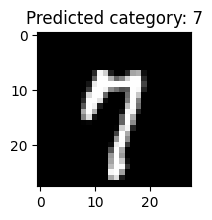

In [62]:
# Take an image from the test set
sample_idx = torch.randint(len(test), size=(1,)).item()
img, lbl = test[sample_idx]

# Generate the prediction
predict(model, img)